In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from dotenv import load_dotenv

sns.set_theme()

##### Set the current working directory to the root of your project
os.chdir("/Users/evan/Documents/School/MSDS/msds-capstone/vm-spinal-risk/vm-spinal-risk/")


from utilities import data_processing as dp_utils
from utilities import eda_tools as eda_utils

In [2]:
processed_df = pd.read_csv('./data/all_risk_processed.csv')
# processed_df = dp_utils.get_spinal_risk_score(processed_df)

In [4]:
processed_df['old_spinal_risk_score'] = processed_df['spinal_risk_score']

In [5]:
processed_df = dp_utils.get_spinal_risk_score(processed_df)

In [12]:
processed_df.to_csv('./data/all_risk_processed.csv')

Text(0, 0.5, 'New Spinal Risk score')

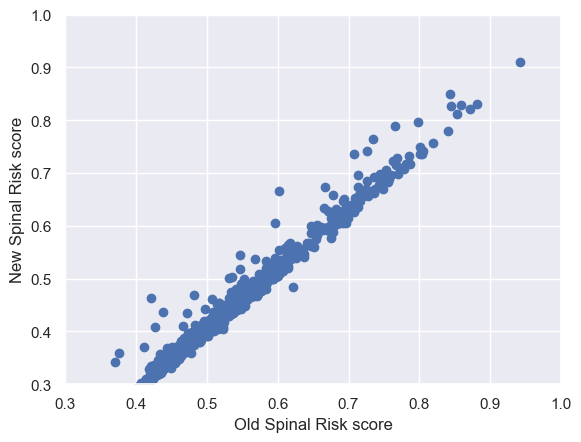

In [11]:
plt.scatter(processed_df.spinal_risk_score, processed_df.old_spinal_risk_score)
plt.xlim([0.3, 1])
plt.ylim([0.3, 1])
plt.xlabel('Old Spinal Risk score')
plt.ylabel('New Spinal Risk score')

In [6]:
processed_df.head()

,record_id,risk_1_timestamp,age,sex,height,weight,zipcode,ethnicity,income,education,...,province_code,latitude,longitude,fips,GISJOIN,FIPS,ADI_NATRANK,ADI_STATERNK,spinal_risk_score,old_spinal_risk_score
0,3,1/26/2024 22:04,25,1,18,36,76177,4,4,6,...,439.0,32.9448,-97.3124,4.843911e+11,G48043901139401,4.843911e+11,34,2,0.843445,0.850389
1,6,1/26/2024 22:04,28,1,25,77,32226,4,13,6,...,31.0,30.4735,-81.5448,1.203101e+11,G12003100101071,1.203101e+11,55,6,0.725933,0.740909
2,22,1/26/2024 22:04,20,2,16,25,28729,4,11,6,...,89.0,35.3172,-82.5977,3.708993e+11,G37008909307033,3.708993e+11,47,3,0.512651,0.426640
3,4,1/26/2024 22:04,31,1,23,131,94041,5,6,7,...,85.0,37.3893,-122.0783,6.085510e+10,G06008505096003,6.085510e+10,1,1,0.598028,0.511215
4,21,1/26/2024 22:04,25,1,26,106,50010,2,4,7,...,169.0,42.0379,-93.6003,1.916900e+11,G19016900001011,1.916900e+11,30,1,0.881841,0.830583


In [4]:
processed_df.to_csv('./data/all_risk_processed.csv', index=False)


In [2]:
odi_df = pd.read_csv('./data/all_risk_processed.csv')
odi_df = odi_df.rename(columns={'ADI_NATRANK':'adi_score'})


In [8]:
# Removing incomplete data
odi_quality_df = odi_df[odi_df['risk_1_timestamp'] != '[not completed]']

In [12]:
# odi_df = dp_utils.filter_df_by_attention_check(odi_df, 20, 26, 4, remove=False)
# odi_quality_df = odi_df[odi_df['pass_att_check'] == True]

adi_scores = odi_quality_df.copy().adi_score
odi_quality_df['adi_score'] = pd.to_numeric(adi_scores, errors='coerce')

/var/folders/4f/fzllrn4502l9flldxbwxtf9m0000gn/T/ipykernel_49864/3702306154.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odi_quality_df['adi_score'] = pd.to_numeric(adi_scores, errors='coerce')


In [13]:
odi_quality_df.adi_score

0      34.0
1       1.0
2      13.0
3      55.0
4      52.0
       ... 
740    94.0
741    25.0
742    39.0
743    64.0
744     2.0
Name: adi_score, Length: 734, dtype: float64

(array([96., 75., 65., 86., 87., 73., 87., 52., 52., 43.]),
 array([  1. ,  10.9,  20.8,  30.7,  40.6,  50.5,  60.4,  70.3,  80.2,
         90.1, 100. ]),
 <BarContainer object of 10 artists>)

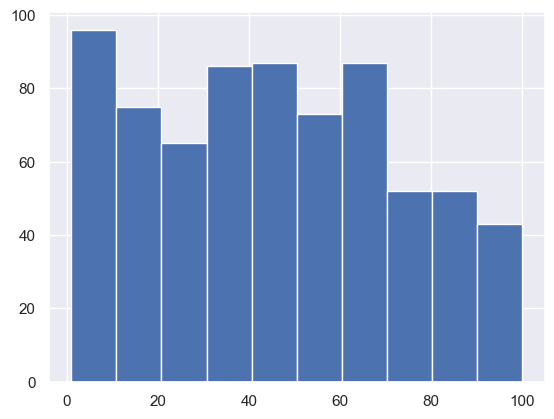

In [14]:
plt.hist(odi_quality_df.adi_score)

In [15]:
odi_quality_df[['record_id', 'state']].groupby('state').count().reset_index().sort_values('record_id', ascending=False)

,state,record_id
3,California,101
40,Texas,66
8,Florida,59
30,New York,38
31,North Carolina,27
44,Washington,26
12,Illinois,26
35,Pennsylvania,24
32,Ohio,23
28,New Jersey,19


In [17]:
from tableone import TableOne

## Create an instance of TableOne with the input arguments
columns = [
       'age',
       'sex', 
       'height_m', 
       'weight_kg', 
       'bmi',
       # 'how_physically_demanding_i', 
       # 'have_you_ever_experienced',
       # 'how_have_you_addressed_add', 
       'age_range',
       'adi_score', 
       'odi_final',]
nonnormal = ['odi_final', 'weight_kg', 'bmi', 'adi_score']
categorical = ['age_range', 'sex']
mytable = TableOne(odi_quality_df, columns=columns, categorical=categorical, nonnormal=nonnormal)

mytable
## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))

|                           |       | Missing   | Overall          |
|---------------------------|-------|-----------|------------------|
| n                         |       |           | 734              |
| age, mean (SD)            |       | 0         | 52.0 (19.5)      |
| sex, n (%)                | 1     | 0         | 362 (49.3)       |
|                           | 2     |           | 372 (50.7)       |
| height_m, mean (SD)       |       | 0         | 1.7 (0.1)        |
| weight_kg, median [Q1,Q3] |       | 0         | 77.6 [66.2,91.2] |
| bmi, median [Q1,Q3]       |       | 0         | 25.4 [22.4,29.6] |
| age_range, n (%)          | 20-30 | 0         | 111 (15.1)       |
|                           | 30-40 |           | 121 (16.5)       |
|                           | 40-50 |           | 101 (13.8)       |
|                           | 50-60 |           | 119 (16.2)       |
|                           | 60-70 |           | 106 (14.4)       |
|                           | 70-8

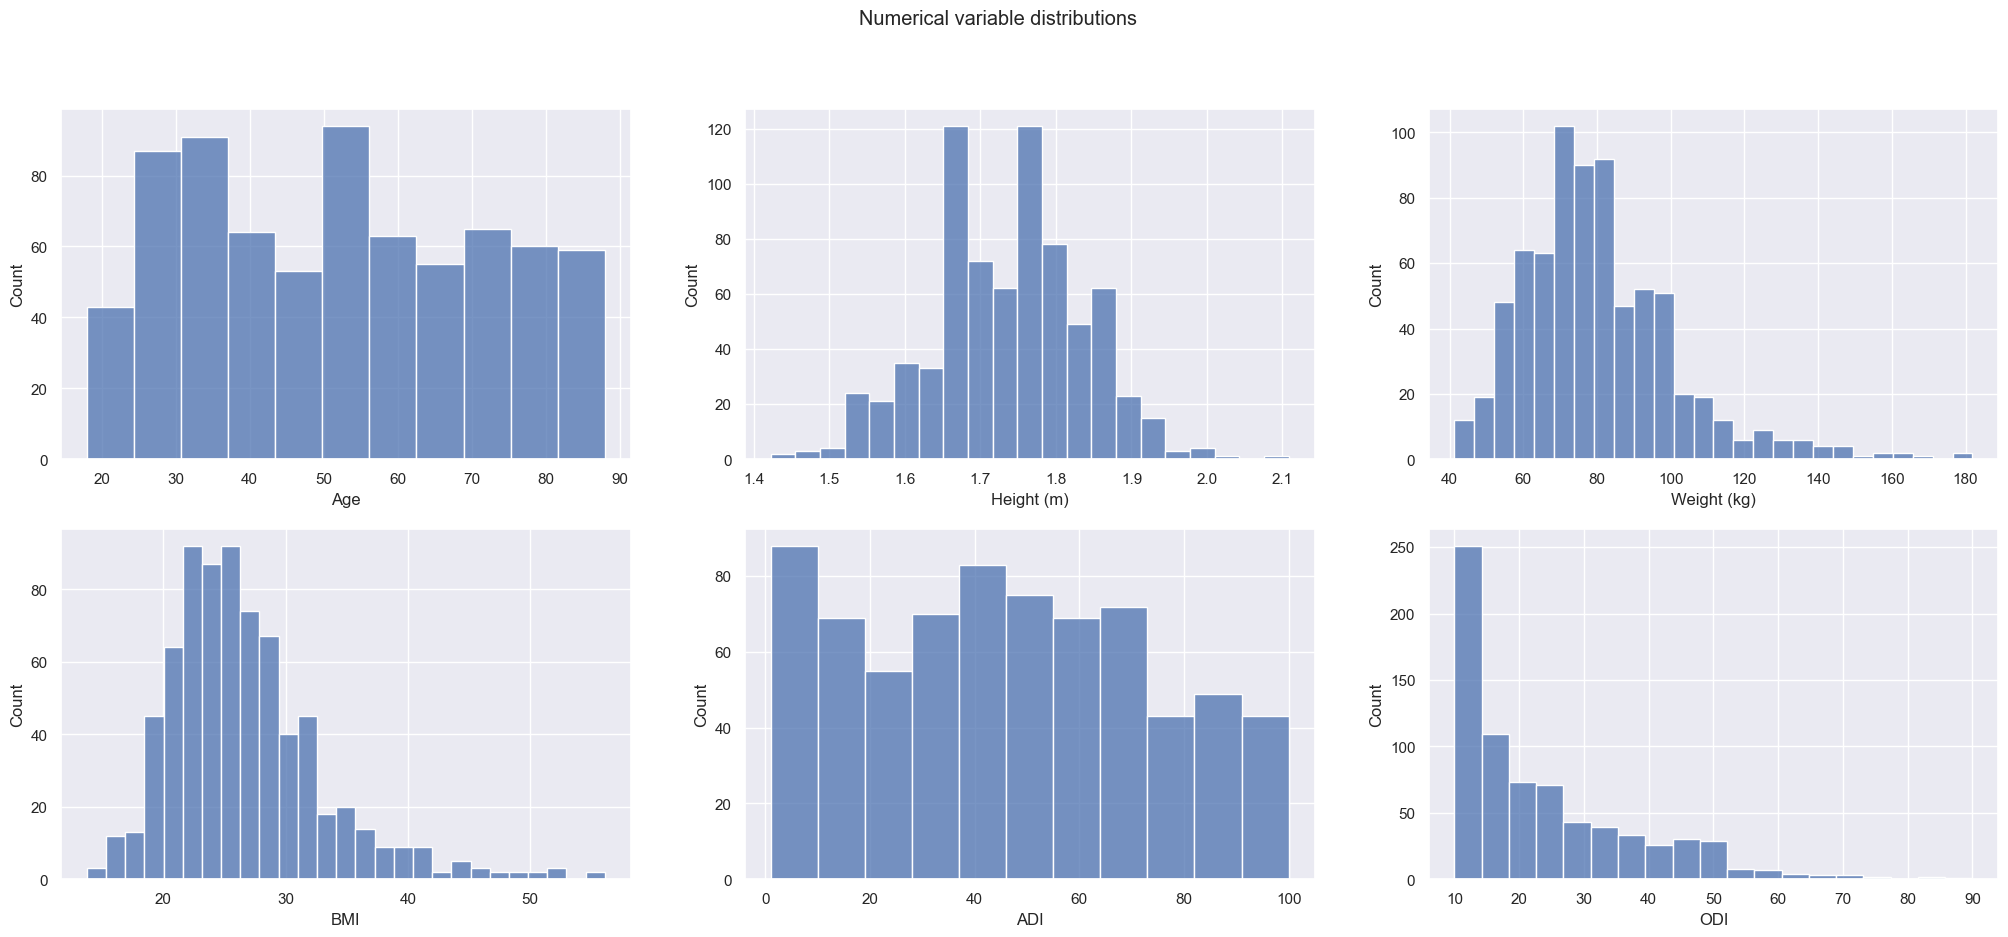

In [18]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

sns.histplot(odi_quality_df['age'], ax=axes[0])
sns.histplot(odi_quality_df['height_m'], ax=axes[1])
sns.histplot(odi_quality_df['weight_kg'], ax=axes[2])
sns.histplot(odi_quality_df['bmi'], ax=axes[3])
sns.histplot(odi_quality_df['adi_score'], ax=axes[4])
sns.histplot(odi_quality_df['odi_final'], ax=axes[5])
plt.suptitle("Numerical variable distributions")
axes[0].set_xlabel("Age")
axes[1].set_xlabel("Height (m)")
axes[2].set_xlabel("Weight (kg)")
axes[3].set_xlabel("BMI")
axes[4].set_xlabel("ADI")
axes[5].set_xlabel("ODI")
plt.show()

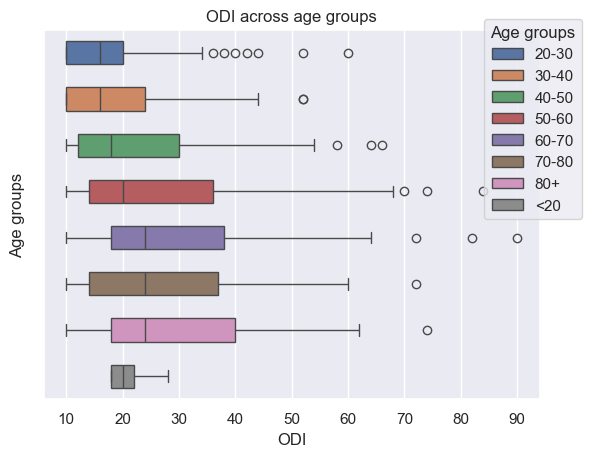

In [19]:
sns.boxplot(odi_quality_df.sort_values('age_range'), x='odi_final', hue='age_range', width=1, gap=0.5)
plt.title("ODI across age groups")
plt.legend(title="Age groups", bbox_to_anchor=(1.1, 1.05))
plt.ylabel("Age groups")
plt.xlabel("ODI")
plt.show()

<Axes: xlabel='odi_final', ylabel='Density'>

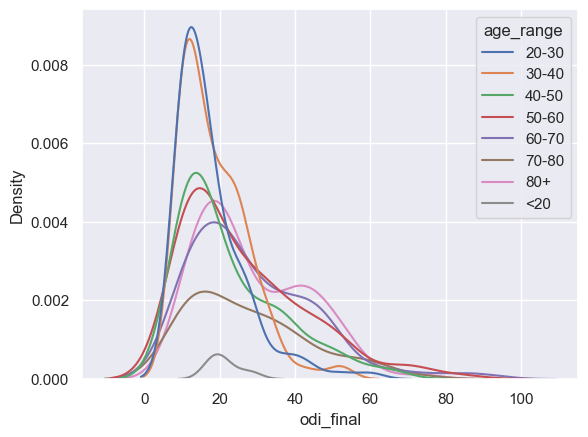

In [20]:
sns.kdeplot(data=odi_quality_df.sort_values('age_range'), x='odi_final', hue='age_range')

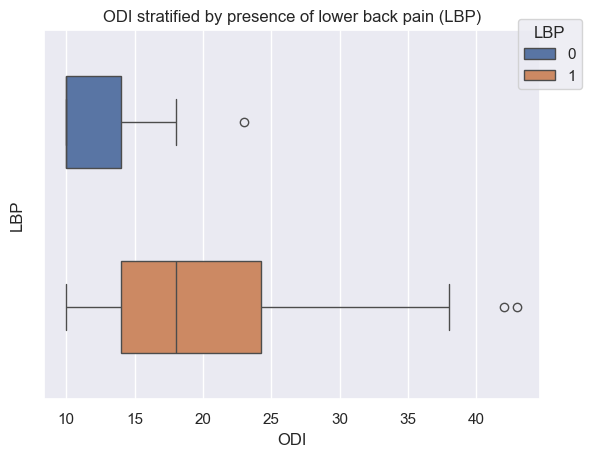

In [110]:
sns.boxplot(odi_quality_df.sort_values('age_range'), x='odi_final', hue='lbp', width=1, gap=0.5)
plt.title("ODI stratified by presence of lower back pain (LBP)")
plt.legend(title="LBP", bbox_to_anchor=(1.1, 1.05))
plt.ylabel("LBP")
plt.xlabel("ODI")
plt.show()

In [21]:
# ODI
nonnormal = ['odi_final']
categorical = ['age_range', 'sex']
columns = nonnormal + categorical
mytable = TableOne(odi_quality_df, columns=columns, categorical=categorical, nonnormal=nonnormal, groupby=['sex'], pval=True)

## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))
# mytable

|                           |       | Missing   | Overall          | 1                | 2                | P-Value   |
|---------------------------|-------|-----------|------------------|------------------|------------------|-----------|
| n                         |       |           | 734              | 362              | 372              |           |
| odi_final, median [Q1,Q3] |       | 0         | 20.0 [12.0,32.0] | 17.0 [12.0,28.0] | 22.0 [14.0,34.0] | <0.001    |
| age_range, n (%)          | 20-30 | 0         | 111 (15.1)       | 61 (16.9)        | 50 (13.4)        | <0.001    |
|                           | 30-40 |           | 121 (16.5)       | 71 (19.6)        | 50 (13.4)        |           |
|                           | 40-50 |           | 101 (13.8)       | 56 (15.5)        | 45 (12.1)        |           |
|                           | 50-60 |           | 119 (16.2)       | 48 (13.3)        | 71 (19.1)        |           |
|                           | 60-70 |           

In [112]:
# ODI
nonnormal = ['odi_score']
categorical = ['age_range', 'sex']
columns = nonnormal + categorical
mytable = TableOne(odi_quality_df, columns=columns, categorical=categorical, nonnormal=nonnormal, groupby=['age_range'], pval=True)

## Display the table using the tabulate method. The tablefmt argument allows the table to be displayed in multiple formats, including “github”, “grid”, “fancy_grid”, “rst”, “html”, and “latex”.:
print(mytable.tabulate(tablefmt="github"))
# mytable.tabulate(tablefmt=)
mytable

|                           |       | Missing   | Overall          | 20-30            | 30-40            | 40-50            | 50-60            | 60-70            | 70-80            | 80+              | P-Value   |
|---------------------------|-------|-----------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|------------------|-----------|
| n                         |       |           | 175              | 22               | 61               | 41               | 21               | 23               | 6                | 1                |           |
| odi_score, median [Q1,Q3] |       | 0         | 17.0 [13.0,24.0] | 15.0 [12.0,23.2] | 15.0 [12.0,22.0] | 21.0 [16.0,28.0] | 20.0 [16.0,23.0] | 16.0 [12.5,24.0] | 15.5 [15.0,20.5] | 17.0 [17.0,17.0] | 0.042     |
| age_range, n (%)          | 20-30 | 0         | 22 (12.6)        | 22 (100.0)       |                  |                  |                  |

Grouped by age_range                                                                                                                                                        
                                             Missing           Overall             20-30             30-40             40-50             50-60             60-70             70-80               80+ P-Value
n                                                                  175                22                61                41                21                23                 6                 1        
odi_score, median [Q1,Q3]                          0  17.0 [13.0,24.0]  15.0 [12.0,23.2]  15.0 [12.0,22.0]  21.0 [16.0,28.0]  20.0 [16.0,23.0]  16.0 [12.5,24.0]  15.5 [15.0,20.5]  17.0 [17.0,17.0]   0.042
age_range, n (%)          20-30                    0         22 (12.6)        22 (100.0)                                                                                                              <0.001
                          30-40                              61 (34.9)                          61 (100.0)                                                                                                  
                          40-50                              41 (23.4)                                            41 (100.0)                                                                                
                          50-60                              21 (12.0)                                                              21 (100.0)                                                              
                          60-70                              23 (13.1)                                                                                23 (100.0)                                            
                          70-80                                6 (3.4)                                                                                                   6 (100.0)                          
                          80+                                  1 (0.6)                                                                                                                     1 (100.0)        
sex, n (%)                1                        0         68 (38.9)          7 (31.8)         27 (44.3)         13 (31.7)          8 (38.1)         10 (43.5)          2 (33.3)         1 (100.0)   0.683
                          2                                 107 (61.1)         15 (68.2)         34 (55.7)         28 (68.3)         13 (61.9)         13 (56.5)          4 (66.7)                          
[1] Chi-squared tests for the following variables may be invalid due to the low number of observations: age_range, sex.

Correlations plots

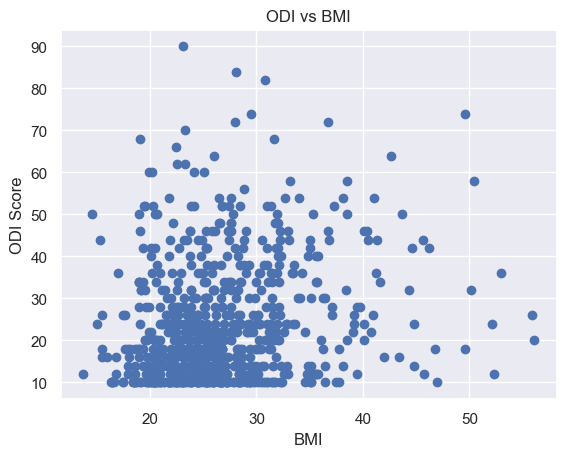

In [22]:
fig, ax = plt.subplots()
ax.plot(odi_quality_df['bmi'], odi_quality_df['odi_final'], 'o')
ax.set_ylabel('ODI Score')
ax.set_xlabel('BMI')
ax.set_title("ODI vs BMI")
plt.show()

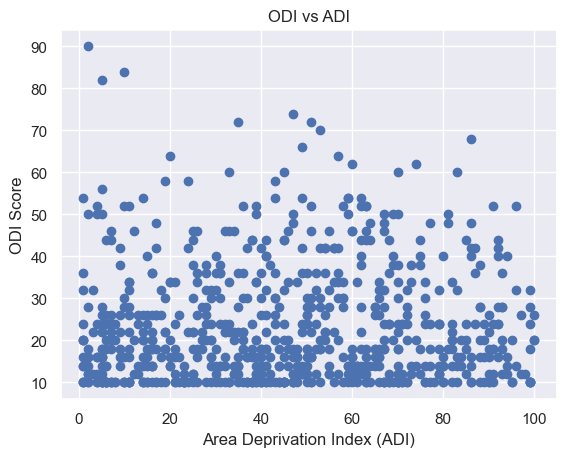

In [23]:
fig, ax = plt.subplots()
ax.plot(odi_quality_df['adi_score'], odi_quality_df['odi_final'], 'o')
ax.set_ylabel('ODI Score')
ax.set_xlabel('Area Deprivation Index (ADI)')
ax.set_title("ODI vs ADI")
plt.show()